# Challenge : Humpback Whale Identification

> - Ce Challenge de Kaggle qui a pour destination l'identification du nom de baleines déjà identifiée.
- Dans le cas où celle-ci n'est pas 'connue' elle doit être catégorisée comme étant new_whale
- Le fichier de soumission doit contenir le nom de l'image de test ainsi que 5 prédictions de noms de baleines
- Le fait d'ajouter un 2e, 3e ... nom ne pénalise pas plus, il est donc souhaitable de remplir les 5 noms possibles.
- Le réusultat prend en compte l'ordre de prédiction des noms
    - si le bon nom de prédiction est position en 1e position la 'note' maximum sera obtenue pour cette prédiction d'image : 1
    - si le bon nom est en position 2 : 1/2
    - en 3 : 1/3
    - en 4 : 1/4
    - en 5 : 1/5<br>

C'est la moyenne des notes de toutes les images qui est la mesure de performance

<div class="alert alert-block alert-warning">
$$MAP@5=\frac{1}{U}\sum_{u=1}^{U}\sum_{k=1}^{min(n,5)}P(k)×rel(k)$$<br>
</div>
<center>où</center>
- U est le nombre d'images<br>
- P(k) est la précision à l'index k<br>
- n le nombre de prédiction pour l'image<br>
- rel(k) la fonction indicatrice qui vaut 1 si le label à la position k est juste 0 sinon<br>

Tests Naifs: 
    - Soumission_V0 : Reprise du fichier d'origine avec les noms des bonnes images -> 0.277 [place 1759]
        'new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c' pour chaque image
    - Soumission_V1 : Le fichier reprend new_whale en 2e position -> 0.139
        'w_23a388d new_whale w_9b5109b w_9c506f6 w_0369a5c'
        
[ A cette heure : 1981 participants -- Les notes se basent sur seulement 20 % des données du fichier de soumission ]

# PLAN

<h2><font color=blue>[1. Exploration des Données](#section1)</font></h2><br>
1. [Découverte des données](#section1.1)<br>
1. [Visualisation des Images](#section1.2)<br>
1. [Répartition des Données](#section1.3)<br>
    
<h2><font color=blue>[2. Problèmes soulevés par ce Challenge](#section2)</font></h2><br>
1. [La problématique Générale du KAGGLE](#section2.1)<br>
1. [Les Difficultés liées aux données](#section2.2)<br>
    1. [Transfer Learning](#section2.2.1)<br>
    1. [Data Augmentation](#section2.2.2)<br>

<h2><font color=blue>[3. La Modélisation](#section3)</font></h2><br>
1. [CNN](#section3.1)<br>
1. [Process](#section3.2)<br>
1. [Pré-Traitement sur les Images](#section3.3)<br>

<h1>PLAN A REPRENDRE ICI</h1>
<h2><font color=blue>[4. Les Résultats de la modélisation](#section4)</font></h2><br>
1. [XXX](#section4.1)<br>

<h2><font color=blue>[5. Les Résultats](#section5)</font></h2><br>
1. [XXX](#section5.1)<br>

<h2><font color=blue>[6. Amélioration du fichier de Soumission](#section6)</font></h2><br>
[ -> Jeux sur la répartition par seuil](#section6.1)<br>


<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-warning">
<b>Example:</b> Use yellow boxes for examples that are not 
inside code cells, or use for mathematical formulas if needed.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-danger">
<b>Just don't:</b> In general, avoid the red boxes. These should only be
used for actions that might cause data loss or another major issue.
</div>

<a id='section1'></a>

# Exploration des Données

In [1]:
dir_data = './../DATAS/data/'

dir_image_train = dir_data + 'train/'
dir_image_test = dir_data + 'test/'
csv_file = dir_data + 'train.csv'

#### Librairies 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
## Fonctions Utiles
from keras.preprocessing.image import ImageDataGenerator, image
from Utils import TransformImage

Using TensorFlow backend.


<a id='section1.1'></a>

## Découverte des Données

In [4]:
df_train = pd.read_csv(csv_file)

In [5]:
df_train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
df_train.shape, len(os.listdir(dir_image_train)), len(os.listdir(dir_image_test))

((25361, 2), 25361, 7960)

In [7]:
len(set(list(df_train.Image))-set(os.listdir(dir_image_train)))

0

> Nous avons donc 25 361 images dans le répertoire d'entrainement, avec les mêmes noms d'images que celles du fichier 'train.csv' 

> Nous avons 7 960 images dans le répertoire de test pour générer les fichiers de soumission

<a id='section1.2'></a>
## Visualisation des Images
-----

In [8]:
df_train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [15]:
def image_with_index(idx):
    return np.array(image.load_img(dir_image_train + df_train.loc[idx].Image))

def image_name_id_from_index(idx):
    val = df_train.loc[idx]
    return '{} / {}'.format(val['Image'], val['Id'])

def get_image_name_id_from_index(idx):
    return df_train.loc[idx]['Image']

def image_with_name(image_name):
    return np.array(image.load_img(dir_image_train + image_name))

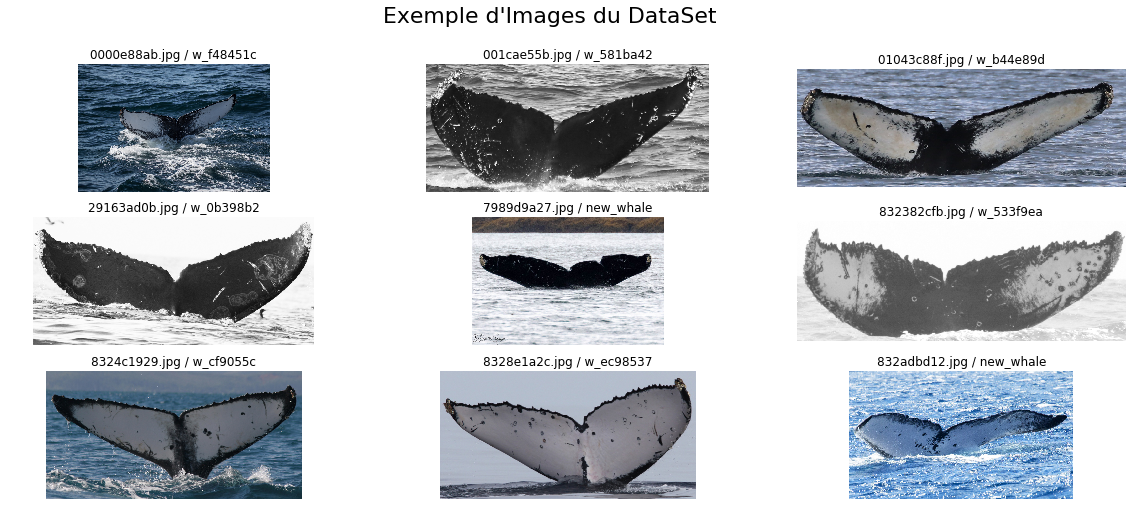

In [10]:
l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]

fig, ax = plt.subplots(3, 3, figsize=(20, 8))
ax = ax.ravel()

for idx_axe, idx_image in enumerate(l_index_image_dataSet):
    ax[idx_axe].imshow(image_with_index(idx_image))
    ax[idx_axe].axis('off')
    ax[idx_axe].set_title(image_name_id_from_index(idx_image))

plt.suptitle("Exemple d'Images du DataSet", fontsize=22)
plt.show()

> Regardons des Images appartenant à la même classe

<a id='section1.3'></a>
## Répartition des Données
-----
> Nous allons regarder la distribution des données en fréquence

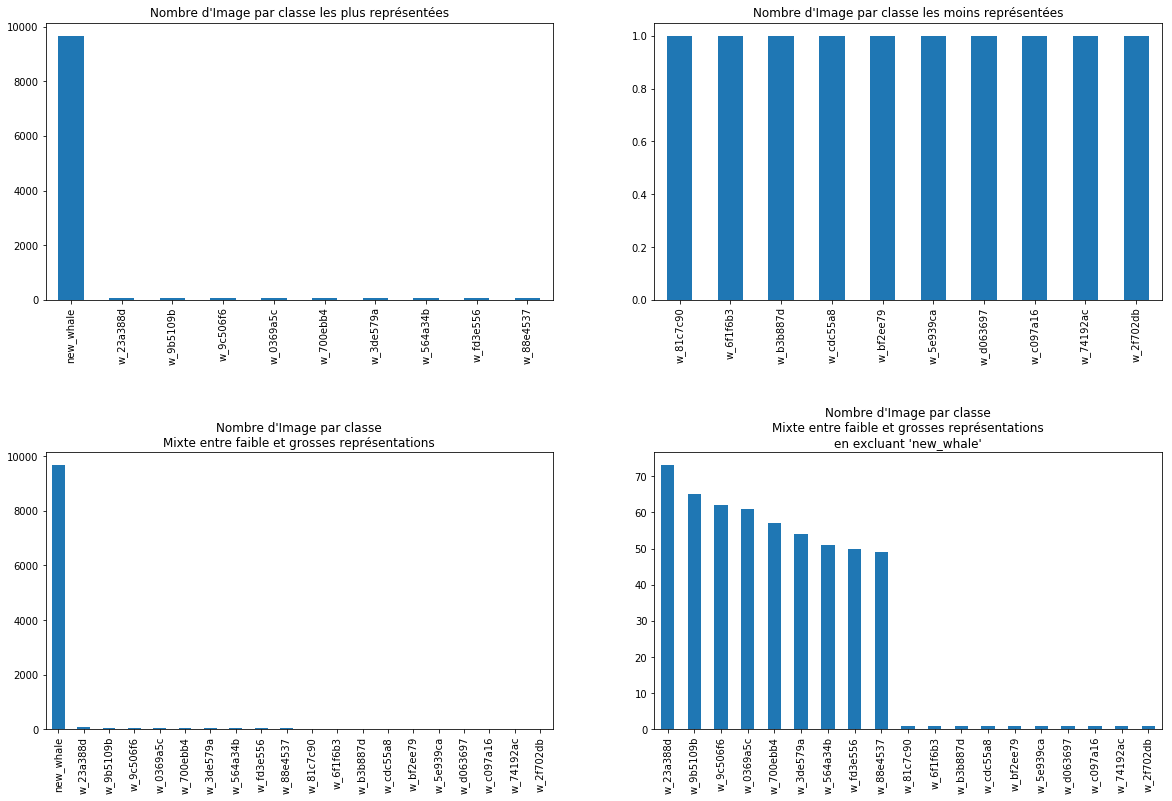

In [11]:
Head = df_train.Id.value_counts().sort_values(ascending=False).head(10)
Tail = df_train.Id.value_counts().sort_values(ascending=False).tail(10)
All = df_train.Id.value_counts().sort_values(ascending=False)
t2 = pd.concat([Head, Tail])

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
fig.subplots_adjust(hspace=0.55)
ax = ax.ravel()

u1 = Head.plot(kind='bar', ax=ax[0],  title="Nombre d'Image par classe les plus représentées")
Tail.plot(kind='bar', ax=ax[1], title="Nombre d'Image par classe les moins représentées")
t2.plot(kind='bar', ax=ax[2],  title="Nombre d'Image par classe\nMixte entre faible et grosses représentations")
t2[t2.values<2000].plot(kind='bar', ax=ax[3],  title="Nombre d'Image par classe\n"
                        "Mixte entre faible et grosses représentations\nen excluant 'new_whale'")

plt.show()

In [12]:
# Nombre d'images pour les classes les plus représentées
Head

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
Name: Id, dtype: int64

In [13]:
print('Nombre de classes différentes : ', df_train.Id.nunique())

Nombre de classes différentes :  5005


> on remarque une disparité très importante entre la représentation de 'new_whale' (c'est normal) et les autres

In [14]:
def tag_from_frequence(freq_in):
    if freq_in>=1000: return '[ 80, $\infty$ ['
    elif freq_in>=50: return '[ 50, 80 ['
    elif freq_in>=20: return '[ 20, 50 ['
    elif freq_in>=10: return '[ 10, 20 ['
    elif freq_in>=6: return '[ 6, 10 ['
    elif freq_in>=5: return '[ 5 ]'
    elif freq_in>=4: return '[ 4 ]'
    elif freq_in>=3: return '[ 3 ]'
    elif freq_in>=2: return '[ 2 ]'
    else: return '[ 1 ]'
    
def tag_from_frequence_order(freq_in):
    if freq_in>=1000: return 16
    elif freq_in>=50: return 15
    elif freq_in>=20: return 14
    elif freq_in>=10: return 13
    elif freq_in>=6: return 12
    elif freq_in>=5: return 11
    elif freq_in>=4: return 10
    elif freq_in>=3: return 9
    elif freq_in>=2: return 8
    else: return 0

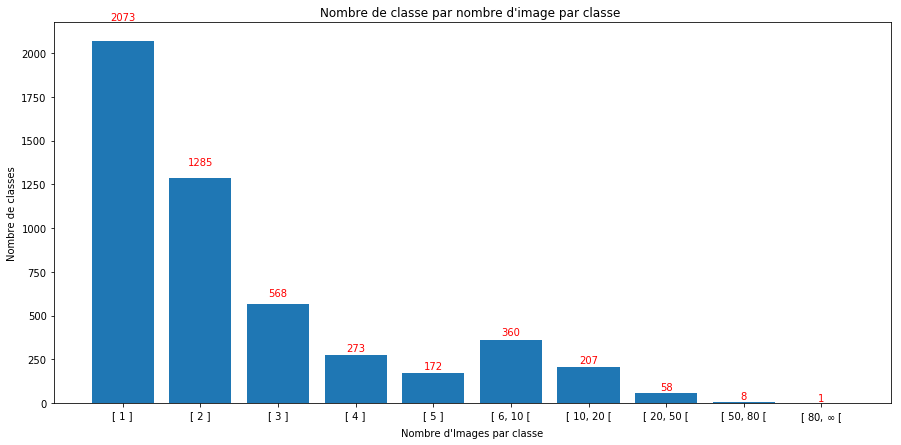

In [15]:
ensembles = [ tag_from_frequence(x) for x in df_train.Id.value_counts().values]
ensembles_ord = [ tag_from_frequence_order(x) for x in df_train.Id.value_counts().values]
t1 = pd.DataFrame({'Ensemble':ensembles, 'Ordre':ensembles_ord})
t2 = t1.groupby(['Ensemble', 'Ordre']).size().reset_index(name='Freq')
t2.sort_values(by=['Ordre'], inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(15, 7, forward=False)
rect1 = plt.bar(x=t2['Ensemble'], height=t2['Freq'], data=t2['Freq'])
plt.title("Nombre de classe par nombre d'image par classe ")
plt.xlabel("Nombre d'Images par classe")
plt.ylabel("Nombre de classes")


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom', color='red')

autolabel(rect1)




plt.show()

<a id='section2'></a>
# Problèmes soulevés par ce Challenge
-----

<a id='section2.1'></a>
## La problématique Générale du KAGGLE
-----
<div class="alert alert-block alert-info">
<b>RAPPEL : </b><br> 
Le dépôt du résultat se fait sous la forme d'un fichier comprenant pour chaque image à prédire, une liste de 5 noms de classe de baleine.<br><br> 
Si la bonne classe est identifiée, sa place dans la liste de 5 noms proposés rapporte plus ou moins de 'points'
La moyenne des points pour l'ensemble des 7 960 images nous donne le score pour le challenge.
</div>

<div class="alert alert-block alert-warning">
<b>A titre d'exemple:</b> Le fichier 'template' de résultat proposé, comprenant "new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c" comme propositions de noms pour chaque image obtient (à l'analyse actuelle de 20% des prédictions de notre fichier) un score de 0.277.<br>
-> Sachant que les images labellisées 'new_whale' représentent 38 % des images de training.
</div>

> Une stratégie globale pour traiter cette problématique peut donc être de 
1. modéliser l'appartenance de chaque image à une classe plutôt qu'à une autre : problématique de classification
2. proposer la liste de 5 noms les plus probables (et leur probabilité individuelle de prédiction)
3. ordonner la proposition de 5 noms selon ces probabilités, voire selon une 2e vérification de ces probabilités
4. la classe 'new_whale' est une classe 'fourre-tout', c'est à dire qu'on doit y mettre les images qui ne correspondent pas à la même classe qu'une image déjà vue et labellisée<br>
Il semble donc nécessaire de comparer les solutions entre 
    1. la détection à l'appartenance à cette classe 
    2. la non appartenance à une autre classe

> TODO: 
    - Proposer les Stratégies: 
        1. Modéliser la classification (new_whale compris) : donner les 5 meilleurs score dans l'ordre (ou avec une pondération à définir)
        2. Modéliser la classification (new_whale compris) : établir une notion de distance à l'appartenance de chaque classe pour ajouter un élément 'new_whale' et sa place à proposer dans la liste des propositions par l'établissement d'un seuil, par clustering, ...
        3. Modéliser la classification (en excluant les images labellisées 'new_whale') : donner les 5 meilleurs score pour la prédiction des images de test, modéliser la détection d'appartenance à 'new_whale' par rapport aux scores des noms proposés.
        4. (solution à présenter après -- est-ce new_whale ou autre : si c'est autre modéliser l'appartenance à tel ou tel groupe) 

<a id='section2.2'></a>
## Les Difficultés liées aux données
------
Pour traiter notre problématique de modélisation de 5005 classes à partir de ces images, l'utilisation du `DEEP LEARNING` au travers d'un `CNN` ( `Convolutional Neural Network`) ou `Réseau de Neurones Convolutionnel` semble adapté

<a id='section2.2.1'></a>
### Transfer Learning

Nous l'avons vu, la distribution des données mises à disposition est désequilibrée, 
- 9 660 images en 'new_whale'
- 66 classes ont entre 20 et 80 images
- 2 000 classes n'ont qu'une seule image
- 1 280 classes n'en ont que 2 ...

Il s'agit donc d'un petit dataSet (faible représentation des classes) pour un grand nombre de classes (5005)<br>

<div class="alert alert-block alert-info">
<b>Solution:</b><br>
-> Une solution adaptée pour traiter cela est le `Tranfer Learning`<br>
Consiste à utiliser un CNN pré-entrainé sur ce même type d'images et donc ayant déjà identifié les features (dans les couches basses).<br>
</div>

Nous allons utiliser des CNN entrainés sur des images d'ImageNet

<a id='section2.2.2'></a>
### Data Augmentation

Dans le cas de CNN où l'on a une faible représentation de certaines classes un principe est très utile c'est celui de la `Data Augmentation` qui consiste à ajouter des images synthétiques générées via des transformations aléatoires à des images existantes.<br>
On peut par exemple faire les transformations suivantes : 
- translations verticales, horizontales
- rotations d'images
- miroring horizontal et vertical 
- modification du contraste de l'image
- zoom avant ou arrière
- réduction de bruit blanc (zca whitening)

Ainsi on augmente son DataSet de données nouvelles qui vont améliorer les performances de l'entrainement du modèle.

<div class="alert alert-block alert-warning">
<b>Dans Keras :</b>  Ces transformations sont facilement réalisables par l'utilisation de la classe de pré-processing `ImageDataGenerator`<br>
Il suffit de paramétrer pour la plupart des paramètres de définir un interval de valeurs de tranformations.<br><br>
- Les images synthétiques sont générées à la volée à chaque appel d'utilisation d'une image pour l'entrainement (et on peut aussi le faire pour la phase de validation et de test)<br>
- Ainsi pour la rotation par exemple on donnera l'angle en degrés $\alpha$ et donc de façon aléatoire les images seront tournées d'un angle compris dans [ - $\alpha$ ; + $\alpha$ ]<br>
- Chaque transformation sera réalisée en même que les autres, avec des valeurs aléatoires indépendantes entre elles dans la limite de ce qui a été paramétré.
</div>




#### Exemple de Data Augmentation

In [5]:
# Definition du ImageDataGenerator c'est à dire les paramètres des transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.40, 0.8],
    zoom_range=[0.7, 1.7],
)

<div class="alert alert-block alert-warning">
Ici nous ne réalisons pas de miroring vertical car les images sont dans le bon sens et on ne trouve pas d'images à l'envers (le ciel en bas)
</div>

In [6]:
MyTransformation = TransformImage(train_datagen, resize_max_pixel=300000, 
                   dir_input=dir_image_train, dir_output=dir_image_train, 
                   prefix_rename='AUG')

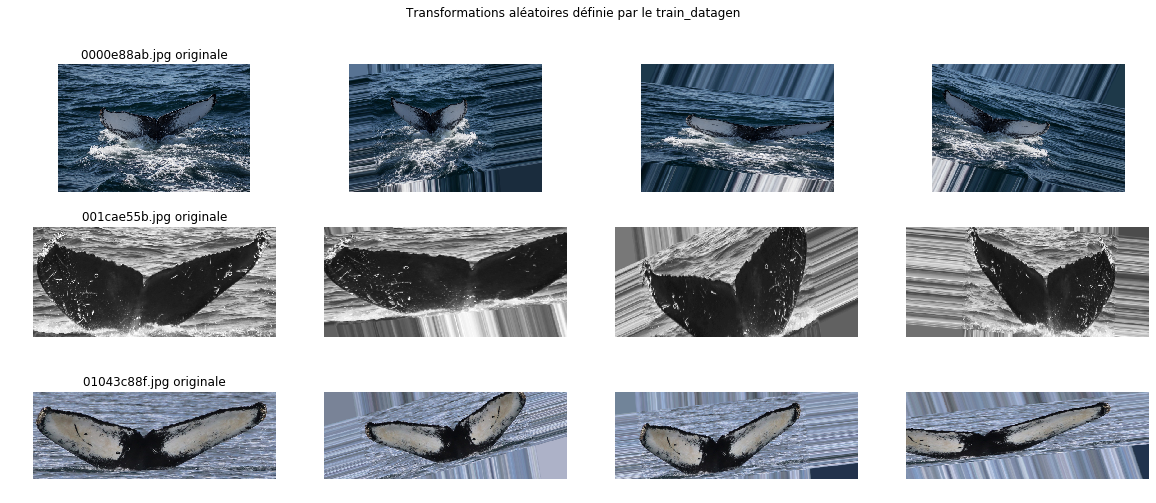

In [51]:
def affiche_transformation(l_index_image_dataSet):
    fig, ax = plt.subplots(3, 4, )
    ax = ax.ravel()
    fig.set_size_inches(20, 8, forward=True)
    #l_index_image_dataSet = [0, 10, 100, 4000, 12000, 13000, 13001, 13002, 13003]
    idx_axe = 0

    for idx, idx_image in enumerate(l_index_image_dataSet):
        image_name = get_image_name_id_from_index(idx_image)
        ax[idx_axe].imshow(image_with_index(idx_image))
        ax[idx_axe].axis('off')
        ax[idx_axe].set_title('{} originale'.format(image_name))
        idx_axe+=1

        for i in range(3):
            ax[idx_axe].imshow(np.array(MyTransformation.transform(filename=image_name)))
            ax[idx_axe].axis('off')
            idx_axe+=1
    plt.suptitle('Transformations aléatoires définie par le train_datagen')
    plt.show()

affiche_transformation([0, 10, 100, ])

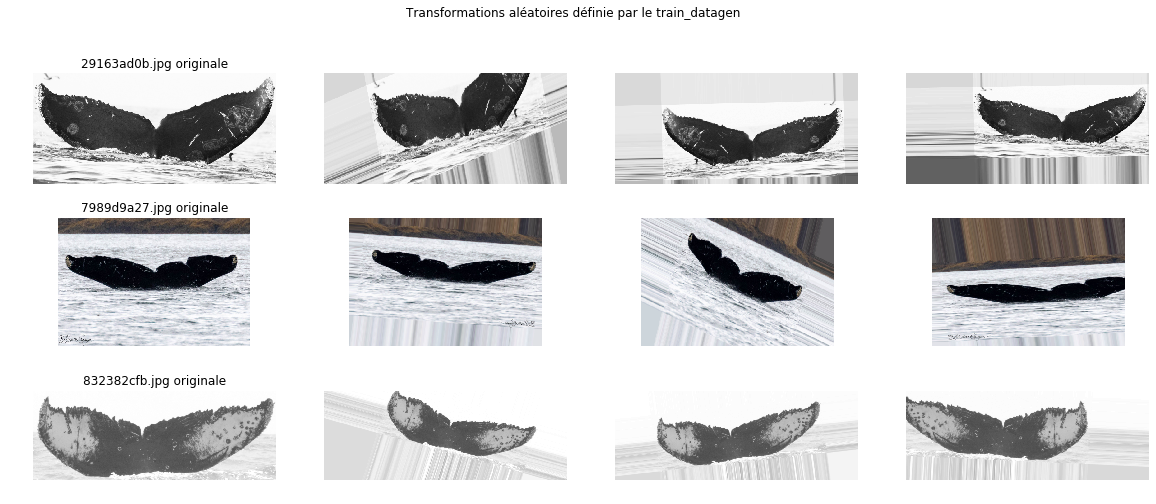

In [52]:
affiche_transformation([4000, 12000, 13000])

#### Très très peu d'Images

Nous avons aussi remarqué que de très nombreuses classes n'ont qu'une image, ou seulement 2 ou 3, ce qui est très peu.<br>
Un problème qui se pose notamment (en plus de la difficulté à optimisser la performance) est qu'il n'est même pas possible de réaliser les différentes phases que sont l'entrainement / la validation et optimisation et le test de performance du modèle avec si peu de données.

<div class="alert alert-block alert-info">
<b>Solution:</b> Dans ce cas aussi nous allons utiliser la `Data Augmentation` à partir des images peu représentées. Les images ainsi générées seront ajoutées au DataSet des images à utiliser.
</div>

<a id='section3'></a>
# La Modélisation
-----

<a id='section3.1'></a>
## CNN

Comme nous l'avons dit nous utilisons un réseau convolutionel de neurones pour faire la classification de nos images.

Nous utilisons ici une solution de `Transfer Learning` à partir du VGG16 pré-entrainé sur les images d'ImageNet (base d'Images initiée par l'équipe de <b>Li Fei-Fei</b> de l'Université de Stanford).

![VGG16](Images/vgg16.png "VGG16")

Des tests ont aussi été réalisés via InceptionV3. 

<a id='section3.2'></a>
## Process

Nous séparons les données de train en 3 parties : `train (60%) / validation (20%) / split (20%`<br>
à l'aide de la fonction train_test_split par stratification, ce qui permet de ne pas avoir de classes non vues dans le train ou la validation ainsi que le fait de pouvoir tester toutes les classes.<br>

Nous passons ces ensembles dans un `ImageDataGenerator`, dans lequel nous appliquons de la Data Augmentation pour les données de Train, et rescallons toutes les données entre [0, 1]<br>

Les données alimentent ensuite le CNN après avoir été resizées en (224, 224) pour l'entrée dans le réseau de neurones.



<a id='section3.3'></a>
## Pré-Traitement sur les Images

Il est à noter que certaines images sont en niveau de gris (255 nuances de gris) et non en RGB.<br>
Cette opérations peut être réalisée en préprocessing par le générateur d'images.

De plus nous savons que pour l'insertion dans le réseau de neurones les images vont être redimensionnées.

L'entrainement des réseaux s'avère très lourd et coûteux en ressources et en temps.

Aussi afin de réduire un peu le temps d'entrainement les images ont toutes été modifiées 'une fois pour toute' afin de gagner du temps au chargement d'images sur des tailles que de toute façon nous savons que nous allons diminuer à chaque étape.

L'opération aurait pû être réalisées en python mais l'a été manuellement à partir de `convert` d'`Image Magick`
```bash 
ls $rep_in | while read toto
	do 
    convert -colorspace Gray $rep_in/$toto -resize 100000@ $rep_out/$toto 
    done
```
L'option -resize 100000@ appliquant un redimensionnement (conservant la résolution) tel que le nombre de pixels ne dépasse pas 100 000<br>
Les images sont donc toutes transformées en niveau de gris

<a id='section4'></a>
# Les Résultats de la modélisation
-----

<a id='section4.1'></a>
## L'entrainement

Les données ont été entrainées sur un serveur `p2.xlarge` chez `AWS EC2`.

Pour un nombre d'EPOCH allant jusqu'à 50 avec un nombre réduit d'images les temps de traitement ont été de 7h avec l'usage de GPU

